In [2]:
# 2018-02-08
# A. Pendleton
# Calculating RNA-Seq stats

In [3]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

### Reading in the sample names / tissues

In [141]:
def get_sample_info():
    #Reading in the RNA-Seq library IDs
    sampleInfo = '/home/ampend/links/kidd-lab/ampend-projects/Novel_Sequence_Analysis/rna-seq/SampleInfoTable.txt'
    sampleDict, tissueDict, samples = {}, {}, []

    for line in open(sampleInfo, 'r'):
        if 'Bio' in line: #skips header
            continue
        line=line.rstrip().split()
        ID = line[4]
        #Rename some tissues to shorter name
        tissue = line[5]
        
        if 'SmoothMuscle' in tissue:
            shortTissue = 'SM'
        if 'Unidentified' in tissue:
            shortTissue = 'NA'
        if 'Blood' in tissue:
            shortTissue = 'BL'
        if 'Brain' in tissue:
            shortTissue = 'BR'
        if 'Heart' in tissue:
            shortTissue = 'HT'
        if 'Ovary' in tissue:
            shortTissue = 'OV'
        if 'Skin' in tissue:
            shortTissue = 'SK'
        if 'Kidney' in tissue:
            shortTissue = 'KD'
        if 'Testis' in tissue:
            shortTissue = 'TS'
        if 'Liver' in tissue:
            shortTissue = 'LV'
        if 'Lung' in tissue:
            shortTissue = 'LG'
        sampleDict[ID] = []
        sampleDict[ID].append(tissue)
        sampleDict[ID].append(shortTissue)
        samples.append(ID)
        

        
        if tissue not in tissueDict.keys():
            tissueDict[tissue] = []
        tissueDict[tissue].append(ID)

    print('%i samples added to a sample array from the following tissues:\n' % len(samples))

    genomes = ['zoey-2.3','canFam3.1-noY']

    for tissue in tissueDict.keys():
        print(tissue)

    return sampleDict, tissueDict, genomes


In [10]:
### REMEMBER TO UNZIP THE FASTQC DIRECTORIES IF YOU WANT TO DO THIS:
### COMMAND = for file in $(ls *.zip); do unzip $file; done; 

def get_initial_fastqc_stats(sampleDict,fastqcDir):
    for sample in sampleDict.keys():
        pairs = ['1','2']
        for i in pairs:
            fastqcFile = fastqcDir + sample + '_%s_fastqc/fastqc_data.txt' % i
            for line in open(fastqcFile,'r'):
                if 'Total Sequences' in line:
                    line=line.rstrip().split()
                    seqCount = line[2]
                if '%GC' in line:
                    line=line.rstrip().split()
                    GC = line[1]
            sampleDict[sample].append(GC)
            sampleDict[sample].append(seqCount)
    return sampleDict

def get_Rcorrected_fastqc_stats(sampleDict,fastqcDir):
    for sample in sampleDict.keys():
        pairs = ['1','2']
        for i in pairs:
            fastqcFile = fastqcDir + 'fixed_%s_%s.cor_fastqc/fastqc_data.txt' % (sample,i)
            for line in open(fastqcFile,'r'):
                if 'Total Sequences' in line:
                    line=line.rstrip().split()
                    seqCount = line[2]
                if '%GC' in line:
                    line=line.rstrip().split()
                    GC = line[1]
            sampleDict[sample].append(GC)
            sampleDict[sample].append(seqCount)
    return sampleDict

def get_Trimmomatic_fastqc_stats(sampleDict,fastqcDir):
    for sample in sampleDict.keys():
        pairs = ['1','2']
        for i in pairs:
            fastqcFile = fastqcDir + 'fixed_%s_cor_trim_%sP_fastqc/fastqc_data.txt' % (sample,i)
            for line in open(fastqcFile,'r'):
                if 'Total Sequences' in line:
                    line=line.rstrip().split()
                    seqCount = line[2]
                if '%GC' in line:
                    line=line.rstrip().split()
                    GC = line[1]
            sampleDict[sample].append(GC)
            sampleDict[sample].append(seqCount)
    return sampleDict

def flagstat_parsing(sampleDict,genomes,bamDirs):
    for bamDir in bamDirs:
        for file in glob.glob(bamDir + '*flagstat'):
            sample = file.replace(bamDir,'').split('_')[0]
            lineCount = 0
            for line in open(file,'r'):
                lineCount += 1
                line=line.rstrip().split()
                if lineCount == 1:
                    totalReads = line[0]
                if lineCount == 3:
                    totalMapped = line[0]            
                if lineCount == 7:
                    properlyPaired = line[0]
                if lineCount == 9:
                    singletons = line[0]
                if lineCount == 10:
                    diffChrom = line[0]
            sampleDict[sample].append(totalReads)
            sampleDict[sample].append(totalMapped)
            sampleDict[sample].append(properlyPaired)
            sampleDict[sample].append(singletons)
            sampleDict[sample].append(diffChrom)
    return sampleDict
                

### Storing per library fastq/read information

In [142]:
scriptsDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/scripts/'
fastqcDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/input/fastqc/'

colInfo = []

#STEP 1 - Build dictionaries to store info
sampleDict, tissueDict, genomes = get_sample_info()
colInfo = ['Sample ID','Tissue Source'] #What columns of info were added to dictionary here

#STEP 2 - Get initial fastqc stats of RAW FASTQ files
fastqcDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/input/fastqc/fastqc_initial/'
sampleDict = get_initial_fastqc_stats(sampleDict,fastqcDir)
colInfo = ['Raw %GC Read 1','Raw Read 1 Counts','Raw %GC Read 2','Raw Read 2 Counts'] #What columns of info were added to dictionary here

#STEP 3 - Get fastqc stats of FASTQ files processed through RCorrector 
fastqcDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/input/fastqc/Fixed_RcorrectedFASTQ_fastqc/'
sampleDict = get_Rcorrected_fastqc_stats(sampleDict,fastqcDir)
colInfo = ['RCorrected %GC Read 1','RCorrected Read 1 Counts','RCorrected %GC Read 2','RCorrected Read 2 Counts'] #What columns of info were added to dictionary here

#STEP 4 - Get fastqc stats of FASTQ files processed through RCorrector + Trimmomatic 
fastqcDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/input/fastqc/trimmomatic-processed/'
sampleDict = get_Trimmomatic_fastqc_stats(sampleDict,fastqcDir)
colInfo = ['Trimmomatic %GC Read 1','Trimmomatic Read 1 Counts','Trimmomatic %GC Read 2','Trimmomatic Read 2 Counts'] #What columns of info were added to dictionary here

#STEP 5 - Get samtools stats of GSNAP alignments with n=10 (10 max alignments per read)
bamDirs = []
inDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Alignments_GSNAP/' 
for genome in genomes:
    bamDir = inDir + genome + '_Rcorrected/'
sampleDict = flagstat_parsing(sampleDict,genomes,bamDirs)
colInfo = ['Zoey Total Reads N=10', 'Zoey Total Mapped Reads N=10', 'Zoey Properly Paired N=10', 'Zoey Singletons N=10', 'Zoey Different Chromosomes N=10']
colInfo = ['CF3 Total Reads N=10', 'CF3 Total Mapped Reads N=10', 'CF3 Properly Paired N=10', 'CF3 Singletons N=10', 'CF3 Different Chromosomes N=10']

#STEP 6 - Get samtools stats of GSNAP alignments with n=1 (1 max alignments per read)
bamDirs = []
inDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Alignments_GSNAP/' 
for genome in genomes:
    bamDir = inDir + genome + '_Rcorrected_n1/'
sampleDict = flagstat_parsing(sampleDict,genomes,bamDirs)
colInfo = ['Zoey Total Reads N=1', 'Zoey Total Mapped Reads N=1', 'Zoey Properly Paired N=1', 'Zoey Singletons N=1', 'Zoey Different Chromosomes N=1']
colInfo = ['CF3 Total Reads N=1', 'CF3 Total Mapped Reads N=1', 'CF3 Properly Paired N=1', 'CF3 Singletons N=1', 'CF3 Different Chromosomes N=1']


#Sort sampleDictionary by tissue type
sort_sampleDict = OrderedDict(sorted(sampleDict.items(), key=lambda x: x[1]))

print(sample,sampleDict['SRR388745'])

f = open('/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/dict.txt','w')

for sample in sort_sampleDict.keys():
    f.write(sample + '\t' + '\t'.join(sort_sampleDict[sample]) + '\n')
f.close()

42 samples added to a sample array from the following tissues:

Blood
Heart
Kidney
SmoothMuscle
Lung
Testis
Skin
Unidentified
Ovary
Brain
Liver
SRR388753 ['SmoothMuscle', 'SM', '52', '10461305', '54', '10461305', '51', '9226755', '53', '9226755', '48', '6706293', '50', '6706293']


## Processing Cufflinks Data

In [143]:
## Parsing cufflinks results
tCounts = {}

for genome in genomes:
    print(genome)
    Dir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Cufflinks_GSNAPAlignments/'
    cuffDir = Dir + '%s_Rcorrected/' % genome
    #PROCESS N=10 CUFFLINKS RESULTS
    for sample in sampleDict.keys():
        gtfFile = cuffDir + sample + '/' + 'transcripts.gtf'
        transcriptCount = count_lines(gtfFile)
        if sample not in tCounts.keys():
            #Structure n10 zoey, n10 canfam, n1 zoey, n1 canfam
            tissue = sampleDict[sample][1]
            tCounts[sample] = [sample,tissue,0,0,0,0,0,0]
        if 'zoey' in genome:
            tCounts[sample][2] = transcriptCount
        else:
            tCounts[sample][3] = transcriptCount
    #PROCESS N=1 CUFFLINKS RESULTS
    Dir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Cufflinks_GSNAPAlignments/'
    cuffDir = Dir + '%s_Rcorrected_n1/' % genome
    for sample in sampleDict.keys():
        gtfFile = cuffDir + sample + '/' + 'transcripts.gtf'
        transcriptCount = count_lines(gtfFile)
        if 'zoey' in genome:
            tCounts[sample][4] = transcriptCount
        else:
            tCounts[sample][5] = transcriptCount
    #PROCESS N=1, OVER-REP REMOVED CUFFLINKS RESULTS
    Dir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Cufflinks_GSNAPAlignments/'
    cuffDir = Dir + '%s_Rcorrected_n1/' % genome
    for sample in sampleDict.keys():
        gtfFile = cuffDir + sample + '/' + 'transcripts.gtf'
        transcriptCount = count_lines(gtfFile)
        if 'zoey' in genome:
            tCounts[sample][4] = transcriptCount
        else:
            tCounts[sample][5] = transcriptCount
            
#SAVE AS DATAFRAME, TRANSPOSE, SORT BY TISSUE
tDict = pd.DataFrame(tCounts).transpose()
tDict.columns = ['Sample','Tissue','Zoey_n10','CF3_n10','Zoey_n1','CF3_n1']
tDict_sort = tDict.sort_values(by=['Tissue','Sample'])
tDict_sort.head()

zoey-2.3
canFam3.1-noY


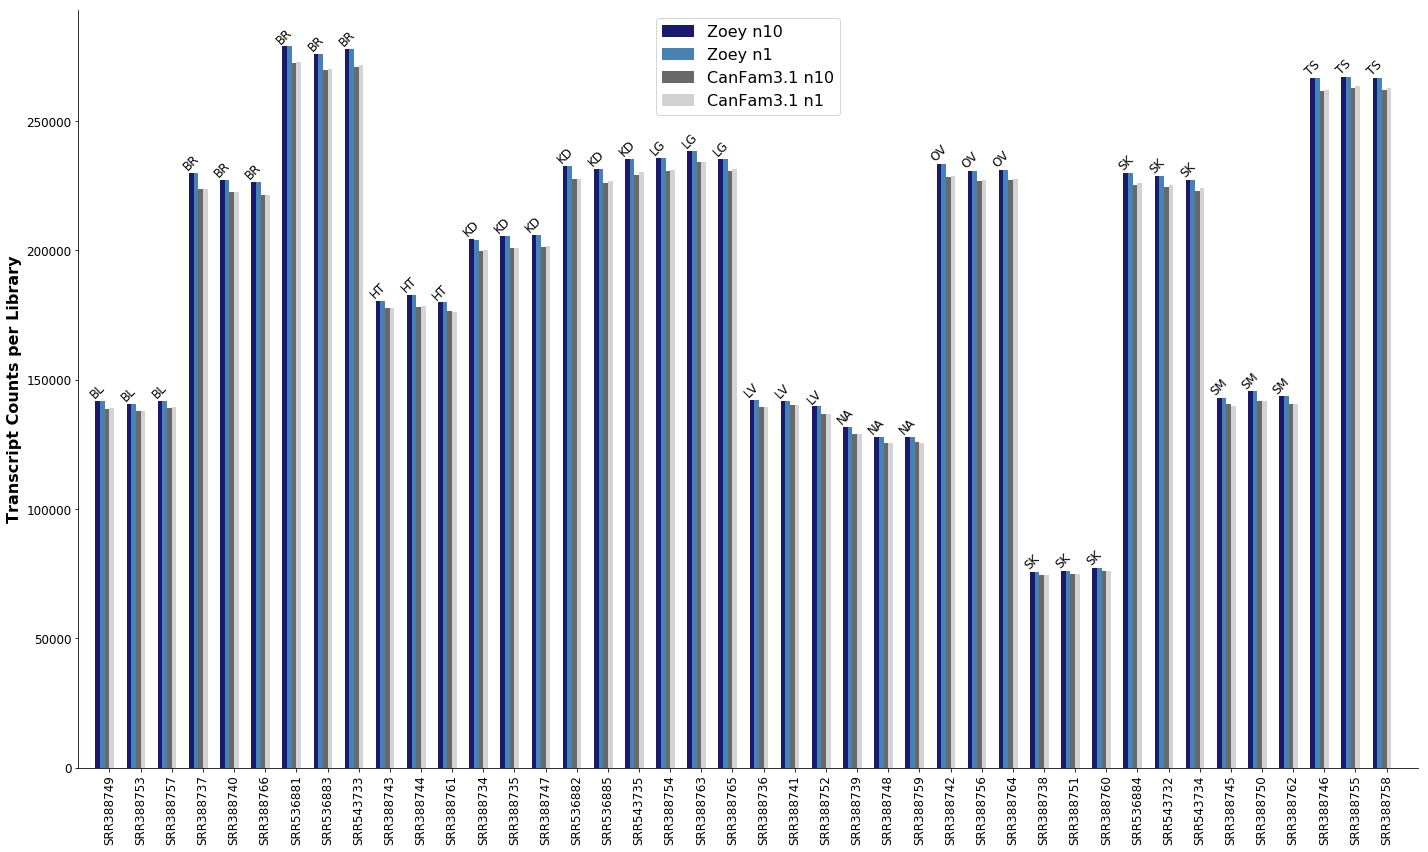

In [162]:
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
plt.ylabel('Transcript Counts per Library',fontweight="bold",fontsize=16)
tDict_sort['Zoey_n10'].plot(kind='bar', color='midnightblue', ax=ax, position=3, width=0.15, align='center', label='Zoey n10')
tDict_sort['Zoey_n1'].plot(kind='bar', color='steelblue', ax=ax, position=2, width=0.15, align='center', label='Zoey n1')
tDict_sort['CF3_n10'].plot(kind='bar', color='dimgray', ax=ax, position=1, width=0.15, align='center', label = 'CanFam3.1 n10')
tDict_sort['CF3_n1'].plot(kind='bar', color='lightgray', ax=ax, position=0, width=0.15, align='center', label='CanFam3.1 n1')
_ = plt.legend(fontsize=16,loc=9)
ax.set_xlim(-1, 42) #adds extra white space between first bar and y-axis

# Add tissue labels to the column pairs
rects = ax.patches
labels = tDict_sort['Tissue'] #get the labels 
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',rotation=45)

plt.tight_layout()
plotDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/plots/'
plotFile = plotDir + 'LibraryCufflinksTranscriptCounts_n10n1.pdf'
plt.savefig(plotFile,transparent=True,bbox_inches = 'tight') #save

simpleaxis(ax)
plt.show()

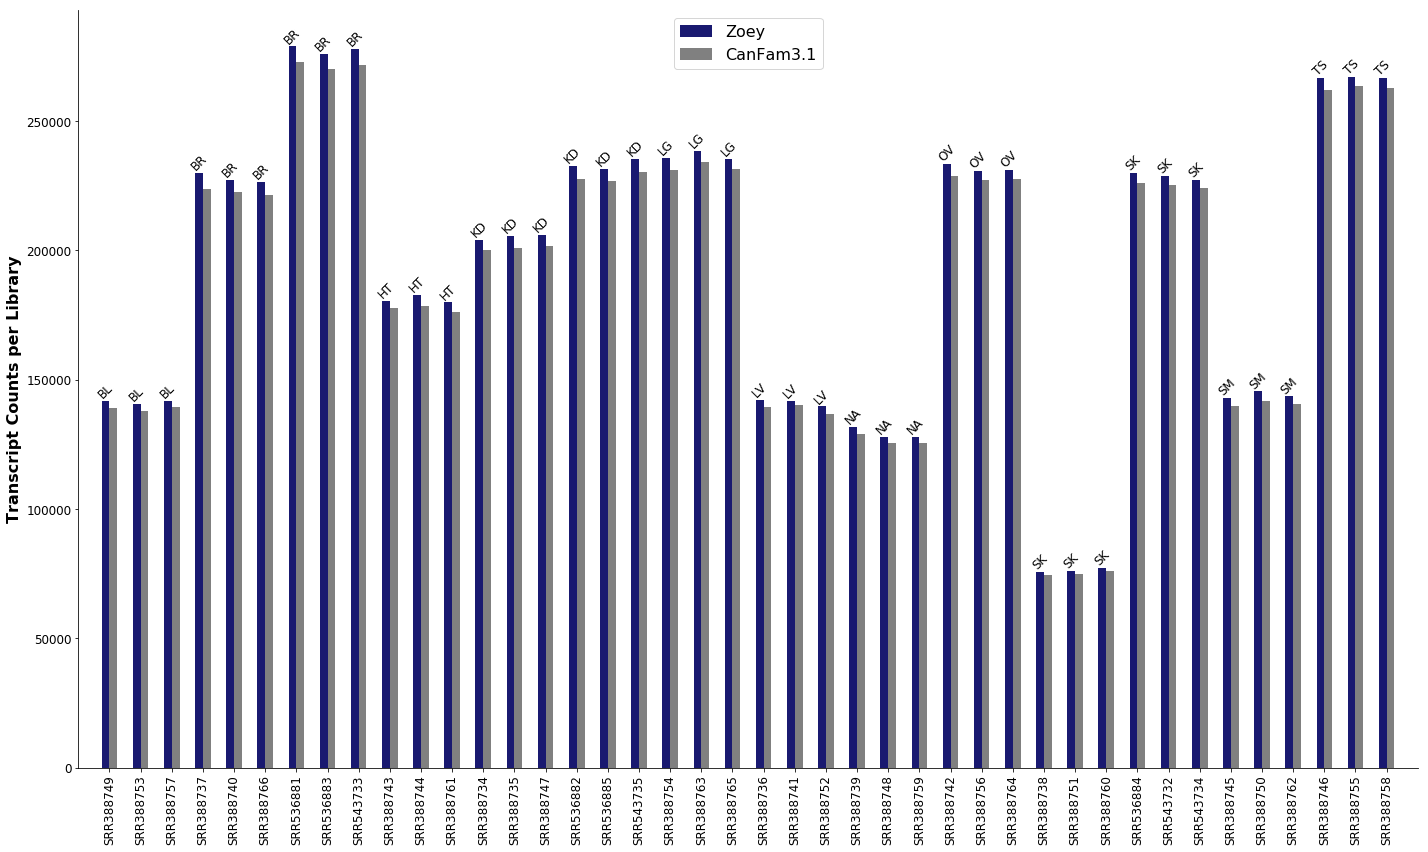

In [167]:
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
plt.ylabel('Transcript Counts per Library',fontweight="bold",fontsize=16)
tDict_sort['Zoey_n1'].plot(kind='bar', color='midnightblue', ax=ax, position=1, width=0.25, align='center', label='Zoey')
tDict_sort['CF3_n1'].plot(kind='bar', color='gray', ax=ax, position=0, width=0.25, align='center', label = 'CanFam3.1')
_ = plt.legend(fontsize=16,loc=9)
ax.set_xlim(-1, 42) #adds extra white space between first bar and y-axis

# Add tissue labels to the column pairs
rects = ax.patches
labels = tDict_sort['Tissue'] #get the labels 
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',rotation=45)

plt.tight_layout()
plotDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/plots/'
plotFile = plotDir + 'LibraryCufflinksTranscriptCounts_n1.pdf'
plt.savefig(plotFile,transparent=True,bbox_inches = 'tight') #save

simpleaxis(ax)
plt.show()